### Using holidays dataset for modelling travel time

Here in this notebook the linear regression model on travel time prediction is made in two cases<br>
1. Using model without using holiday as an attribute
2. Using model with holiday as an attribute <br>
From the both model and predicted time we can see that model predicts the holiday travel time to be lower than the time taken if the day was not a holiday.

In [227]:
import pandas as pd
import numpy as np
import os
import datetime
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error 

In [228]:
time_period_code = {
    1: '[0, 7]',
    2: '[7, 10]',
    3: '[10, 16]',
    4: '[16, 19]',
    5: '[19, 24]'
}

In [229]:
def tp_to_cat(tp):
    for cat,hour in time_period_code.items():
        if hour == tp:
            return cat

In [230]:
holiday_folder = os.path.join('data', 'holiday')
holiday_list_filepath = os.path.join(holiday_folder,'holiday_list.csv')
holiday_sample_filepath=os.path.join(holiday_folder,'holiday_sample.csv')
holiday_list= pd.read_csv(holiday_list_filepath)
holiday_list.day=pd.to_datetime(holiday_list.day)
holiday_sample=pd.read_csv(holiday_sample_filepath)
data_folder = os.path.join('data', 'train')
train_filepath = os.path.join(data_folder,'samples.csv')
holiday_list.head()

,day,occasion
0,2020-01-15,Sankranti
1,2020-01-26,Republic Day
2,2020-02-21,Maha Shivratri
3,2020-03-25,Ugadi
4,2020-04-06,Mahavir Jayanti


In [231]:
holiday_sample.head()

,sourceid,dstid,month,day,time_period,dow,src_lon,src_lat,dst_lon,dst_lat,holiday,distance,google_dist,google_min,google_max
0,9,13,1,15,1,2,77.685723,12.992904,77.645976,13.104998,1,18158.5,19.2,30,45
1,9,13,1,15,3,2,77.685419,12.965401,77.622795,13.099433,1,22980.0,25.2,45,75
2,198,18,1,15,3,2,77.499180,12.885396,77.474105,12.942257,1,8886.4,9.6,20,30
3,198,7,1,15,5,2,77.511597,12.876873,77.686813,13.001213,1,29673.7,29.6,45,75
4,166,198,1,15,4,2,77.696277,12.943712,77.481952,12.893260,1,33261.2,32.2,55,110


In [232]:
sel_input=['time_period', 'dow', 'src_lon', 'src_lat', 'dst_lon', 'dst_lat', 'distance']

In [233]:
train_samples=pd.read_csv(train_filepath)
train_samples.head()

,sourceid,dstid,month,day,start_hour,end_hour,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time,time_period,dow,src_lon,src_lat,dst_lon,dst_lat,distance
0,166,14,3,5,16,19,4267.51,584.94,4228.03,1.15,4,3,77.680209,12.922874,77.622411,13.056525,24164.0
1,132,78,1,30,19,0,2038.28,699.54,1929.37,1.39,5,3,77.563776,12.958184,77.656791,12.976504,12983.0
2,182,96,1,17,19,0,2988.72,843.30,2870.15,1.33,5,4,77.622070,12.865000,77.577098,12.970688,16205.8
3,84,128,3,18,16,19,1347.08,207.92,1331.40,1.16,4,2,77.599931,12.995107,77.551941,12.960545,8585.2
4,166,136,2,22,19,0,2555.25,558.56,2498.95,1.23,5,5,77.680209,12.922874,77.567874,12.948692,16902.8


In [234]:
def hol(date):
      if date in list(holiday_list.day):
        return 1
      else:
        return 0

## Model without holiday

In [235]:
sel_input=['time_period', 'dow', 'src_lon', 'src_lat', 'dst_lon', 'dst_lat', 'distance']
cat_ip=['time_period','dow']
scale_ip= list(set(sel_input)-set(cat_ip))

In [236]:
x = train_samples[sel_input].values
y = train_samples['geometric_mean_travel_time']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=1)

In [237]:
category_Trans= ColumnTransformer([('encoder',OneHotEncoder(categories='auto', sparse=False),[sel_input.index(i) for i in cat_ip]),
                                   ('scaler',StandardScaler(),[sel_input.index(i) for i in scale_ip])],remainder='passthrough')

In [238]:
regressor = Pipeline(steps=[('ct',category_Trans),('model',LinearRegression())])

In [239]:
regressor.fit(x_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OneHotEncoder(sparse=False),
                                                  [0, 1]),
                                                 ('scaler', StandardScaler(),
                                                  [6, 3, 5, 2, 4])])),
                ('model', LinearRegression())])

In [240]:
regressor.score(x_train,y_train)

0.7439553547525597

In [241]:
def predict_time(row):
    Input = row[['time_period', 'dow', 'src_lon', 'src_lat', 'dst_lon', 'dst_lat', 'distance']]
    return round(regressor.predict([Input])[0]/60)

In [242]:
holiday_sample['predicted'] = holiday_sample.apply(predict_time, axis=1)
holiday_sample['google_avg']= holiday_sample.apply(lambda x : math.sqrt(x['google_min']*x['google_max']),axis=1)
results = holiday_sample[['sourceid', 'dstid', 'src_lon', 'src_lat', 'dst_lon', 'dst_lat','distance', 'google_dist', 'google_min', 'google_max','google_avg','predicted']].copy()
results['within_range'] = np.where(
    (results['predicted'] <= results['google_max'])
        & (results['predicted'] >= results['google_min']), 'Y', 'N')
error = math.sqrt(mean_squared_error(holiday_sample['google_avg'],holiday_sample['predicted'])) #calculate rmse
print('RMSE =',error)
percent=results['within_range'].value_counts('Y')[0]
print('Percentage with google range =',percent)
results.head()

RMSE = 8.619088764103427
Percentage with google range = 0.8333333333333334


,sourceid,dstid,src_lon,src_lat,dst_lon,dst_lat,distance,google_dist,google_min,google_max,google_avg,predicted,within_range
0,9,13,77.685723,12.992904,77.645976,13.104998,18158.5,19.2,30,45,36.742346,32,Y
1,9,13,77.685419,12.965401,77.622795,13.099433,22980.0,25.2,45,75,58.094750,56,Y
2,198,18,77.499180,12.885396,77.474105,12.942257,8886.4,9.6,20,30,24.494897,28,Y
3,198,7,77.511597,12.876873,77.686813,13.001213,29673.7,29.6,45,75,58.094750,70,Y
4,166,198,77.696277,12.943712,77.481952,12.893260,33261.2,32.2,55,110,77.781746,86,Y


## Model With Holiday

In [243]:
train_samples.head()

,sourceid,dstid,month,day,start_hour,end_hour,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time,time_period,dow,src_lon,src_lat,dst_lon,dst_lat,distance
0,166,14,3,5,16,19,4267.51,584.94,4228.03,1.15,4,3,77.680209,12.922874,77.622411,13.056525,24164.0
1,132,78,1,30,19,0,2038.28,699.54,1929.37,1.39,5,3,77.563776,12.958184,77.656791,12.976504,12983.0
2,182,96,1,17,19,0,2988.72,843.30,2870.15,1.33,5,4,77.622070,12.865000,77.577098,12.970688,16205.8
3,84,128,3,18,16,19,1347.08,207.92,1331.40,1.16,4,2,77.599931,12.995107,77.551941,12.960545,8585.2
4,166,136,2,22,19,0,2555.25,558.56,2498.95,1.23,5,5,77.680209,12.922874,77.567874,12.948692,16902.8


In [244]:
train_samples['holiday']=train_samples.apply(lambda x: hol(datetime.date(2020,int(x['month']),int(x['day']))), axis=1)

In [245]:
sel_input=['time_period', 'dow', 'src_lon', 'src_lat', 'dst_lon', 'dst_lat', 'distance','holiday']
cat_ip=['time_period','dow']
scale_ip= list(set(sel_input)-set(cat_ip))

In [246]:
x = train_samples[sel_input].values
y = train_samples['geometric_mean_travel_time']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=1)

In [247]:
category_Trans= ColumnTransformer([('encoder',OneHotEncoder(categories='auto', sparse=False),[sel_input.index(i) for i in cat_ip]),
                                   ('scaler',StandardScaler(),[sel_input.index(i) for i in scale_ip])],remainder='passthrough')

In [248]:
regressor = Pipeline(steps=[('ct',category_Trans),('model',LinearRegression())])

In [249]:
regressor.fit(x_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OneHotEncoder(sparse=False),
                                                  [0, 1]),
                                                 ('scaler', StandardScaler(),
                                                  [7, 6, 3, 5, 2, 4])])),
                ('model', LinearRegression())])

In [250]:
def predict_time(row):
    Input = row[['time_period', 'dow', 'src_lon', 'src_lat', 'dst_lon', 'dst_lat', 'distance','holiday']]
    return round(regressor.predict([Input])[0]/60)

In [251]:
holiday_sample['predicted_H'] = holiday_sample.apply(predict_time, axis=1)
holiday_sample['predicted']= results['predicted']
results_holiday = holiday_sample[['sourceid', 'dstid', 'src_lon', 'src_lat', 'dst_lon', 'dst_lat','distance', 'google_dist', 'google_min', 'google_max','google_avg','predicted','predicted_H']].copy()
results_holiday['within_range'] = np.where(
    (results_holiday['predicted_H'] <= results_holiday['google_max'])
        & (results_holiday['predicted_H'] >= results_holiday['google_min']), 'Y', 'N')
error = math.sqrt(mean_squared_error(holiday_sample['google_avg'],holiday_sample['predicted_H'])) #calculate rmse
print('RMSE =',error)
percent=results_holiday['within_range'].value_counts('Y')[0]
print('Percentage with google range =',percent)
results_holiday.head()

RMSE = 9.154912444000464
Percentage with google range = 0.8125


,sourceid,dstid,src_lon,src_lat,dst_lon,dst_lat,distance,google_dist,google_min,google_max,google_avg,predicted,predicted_H,within_range
0,9,13,77.685723,12.992904,77.645976,13.104998,18158.5,19.2,30,45,36.742346,32,30,Y
1,9,13,77.685419,12.965401,77.622795,13.099433,22980.0,25.2,45,75,58.094750,56,53,Y
2,198,18,77.499180,12.885396,77.474105,12.942257,8886.4,9.6,20,30,24.494897,28,25,Y
3,198,7,77.511597,12.876873,77.686813,13.001213,29673.7,29.6,45,75,58.094750,70,67,Y
4,166,198,77.696277,12.943712,77.481952,12.893260,33261.2,32.2,55,110,77.781746,86,83,Y


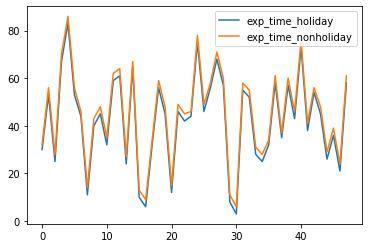

In [253]:
plt.plot(results_holiday['predicted_H'],label='exp_time_holiday')
plt.plot(results_holiday['predicted'],label='exp_time_nonholiday')
plt.legend()